In [70]:
!pip install geopy
!pip install afinn
!pip install textblob

In [71]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
import category_encoders as ce

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob, Blobber
from afinn import Afinn

import time
import squarify
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from geopy.geocoders import Nominatim
from geopy.geocoders import Yandex
import geopy.distance
from geopy import distance

from datetime import datetime as dt

***

# 1. Подгрузка данных

In [72]:
KAGGLE = '/kaggle/input/sf-booking'
LOCAL = 'data'
df_train = pd.read_csv(LOCAL+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(LOCAL+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(LOCAL+'/submission.csv') # самбмишн

### 1.1 Первичные манипуляции с данными и решение задач модуля

In [73]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

data.info() 

C:\Users\Администратор\AppData\Local\Temp\ipykernel_22016\392827872.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### ^ Есть пропущенные значения в широте и долготе (lat, ing)

In [74]:
data['reviewer_nationality'].value_counts().head(10)

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
Name: reviewer_nationality, dtype: int64

### ^ Самые частые гости отелей по национальностям 

In [75]:
# задание 4.2 (количество уникальных отелей)
data['hotel_name'].nunique()

1492

In [76]:
#Задание 4.3 (первый и последний отзыв)
data['review_date'] = pd.to_datetime(data['review_date'])
display(data['review_date'].min())
data['review_date'].max()

Timestamp('2015-08-04 00:00:00')

Timestamp('2017-08-03 00:00:00')

In [77]:
#Задание 4.4 (уникальные теги в наборе данных)
def rev_func(str_tags):
    str_tags = str_tags[2:-2]
    list_tags = str_tags.strip().split(' \', \' ')
    return list_tags

buba = data.copy()

buba['tags_n'] = buba['tags'].apply(rev_func)
buba = buba.explode('tags_n')
len(buba['tags_n'].unique())

2428

In [78]:
#Задание 4.5 , 4.6 (сымый популярный тег и самое частое время пребывания в отеле)
buba['tags_n'].value_counts()

Leisure trip                                417778
Submitted from a mobile device              307640
Couple                                      252294
Stayed 1 night                              193645
Stayed 2 nights                             133937
                                             ...  
Duplex King Suite 3 Adults                       1
Suite Free Executive Lounge Access               1
Suite with Executive Lounge Access               1
Family Room three bedrooms communicating         1
Quadruple Room 2 Adults 2 Children               1
Name: tags_n, Length: 2428, dtype: int64

In [79]:
data['lat'].value_counts()

51.501910    4789
51.511099    4256
51.500961    4169
51.499046    3578
51.510841    3212
             ... 
48.873770      12
51.524422      12
48.817808      10
45.468495      10
48.214507       8
Name: lat, Length: 1472, dtype: int64

***

# 2. Работа с признаками для отелей

In [80]:
# Создадим множество признаков, связанных с отелями
hotel_related_columns = {'hotel_name', 
                         'hotel_address', 
                         'lat', 
                         'lng', 
                         'average_score', 
                         'total_number_of_reviews', 
                         'additional_number_of_scoring' }

# Создадим множество всех колонок датасета и вычтем из них необходимые нам
all_columns = set(data.columns)
columns_to_delete = list(all_columns - hotel_related_columns)

# Дропаем колонки, не относящиеся к отелям
hotels = data.drop(columns_to_delete, axis = 1)
    
hotels

,hotel_address,additional_number_of_scoring,average_score,hotel_name,total_number_of_reviews,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,16670,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,8.6,Urban Lodge Hotel,5018,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,351,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,9.1,Hotel Principe Di Savoia,1543,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,9.1,Hotel Esther a,4687,52.370545,4.888644
...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea London SW5 0TP United Kingdom,107,9.0,Hotel Moonlight,617,51.494028,-0.191050
515734,Landstra er Hauptstra e 155 03 Landstra e 1030 Vienna Austria,272,8.4,BEST WESTERN PLUS Amedia Wien,3224,48.192379,16.399451
515735,29 31 Gower Street Camden London WC1E 6HG United Kingdom,457,6.8,Bloomsbury Palace Hotel,2751,51.520795,-0.131084
515736,31 Great Cumberland Place Westminster Borough London W1H 7TA United Kingdom,365,8.1,The Marble Arch London,1567,51.515125,-0.160066


In [81]:
# Дропаем дублированные имена отелей
hotels.drop_duplicates(subset=['hotel_name'], inplace=True)

# Колонку с именем отеля поставим первой для удобства
hotels.rename(columns={'hotel_name': 'hotel_name_old'}, inplace=True)
hotels.insert(0, 'hotel_name', hotels['hotel_name_old'], allow_duplicates=True)
hotels.drop('hotel_name_old', axis = 1, inplace=True)

# Обновим индекс
hotels.reset_index(drop=True, inplace=True)

# Переименуем все колонки для удобства
hotels.columns = ['name', 'address', 'no_review_scores', 'score', 'reviews', 'lat', 'lng']

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1492 non-null   object 
 1   address           1492 non-null   object 
 2   no_review_scores  1492 non-null   int64  
 3   score             1492 non-null   float64
 4   reviews           1492 non-null   int64  
 5   lat               1475 non-null   float64
 6   lng               1475 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 81.7+ KB


In [82]:
# Посчитаем количество адресов отелей
hotels['address'].value_counts().count()

1491

#### ^ Судя по всему, 2 отеля имеют одинаковый адрес

In [83]:
# Сгруппируем отели по адресу - 'address', посчитаем имена - count() 'name' и отсортируем по убыванию
grouped_addresses = hotels.groupby(['address'])['name'].count().sort_values(ascending=False)

display(grouped_addresses.head(3))

duplicated_address = grouped_addresses.index[0]

print('Duplicated address: '+'\''+duplicated_address+'\'.')

pd.set_option('display.max_colwidth', None)

hotels[hotels['address'] == duplicated_address]

address
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom    2
 s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands                     1
Herengracht 542 556 Amsterdam City Center 1017 CG Amsterdam Netherlands       1
Name: name, dtype: int64

Duplicated address: '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'.


,name,address,no_review_scores,score,reviews,lat,lng
251,Club Quarters Hotel Trafalgar Square,8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,602,8.5,2494,51.506935,-0.126012
529,The Grand at Trafalgar Square,8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,409,8.3,1592,51.506935,-0.126012


#### ^ В Лондоне обнаружились 2 отеля, занимающие одинаковый адрес

In [84]:
# В адресах проглядывается закономерность: Страна - это всегда последних слова, в случае с Великобританией - два слова. Воспользуемся этим
hotels['country'] = hotels['address'].apply(lambda x: x.split()[-1]\
                                            if x.split()[-1] != 'Kingdom'\
                                                    else ' '.join(x.split()[-2:]))

print('There are hotels from '+str(hotels['country'].nunique())+' different countries in the dataset.\n')
print(hotels['country'].value_counts())

# Город - второе слово с конца, Если город в Великобритании - 5

hotels['city'] = hotels['address'].apply(lambda x: x.split()[-2]\
                                         if x.split()[-1] != 'Kingdom'\
                                         else x.split()[-5])

print('\nThere are hotels from '+str(hotels['city'].nunique())+' different cities in the dataset.\n')
print(hotels['city'].value_counts())

There are hotels from 6 different countries in the dataset.

France            458
United Kingdom    400
Spain             211
Italy             161
Austria           157
Netherlands       105
Name: country, dtype: int64

There are hotels from 6 different cities in the dataset.

Paris        458
London       400
Barcelona    211
Milan        161
Vienna       157
Amsterdam    105
Name: city, dtype: int64


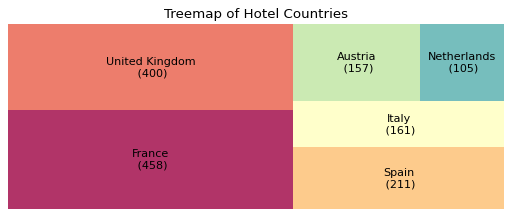

In [85]:
def chart_column_treemap(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    title_fontsize=14,   # title font size
    size=[8, 4]):        # size of the chart

    grouped = df.groupby(col).size().sort_values(ascending=False).reset_index(name='Counts')
    labels = grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = grouped['Counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    plt.figure(figsize=(size[0], size[1]), dpi= 80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    plt.title(title, size=title_fontsize)
    plt.axis('off')
    plt.show();

chart_column_treemap(
    hotels,
    'country',
    'Treemap of Hotel Countries',
    title_fontsize=12,
    size=[8, 3])

In [86]:
hotels[pd.isnull(hotels['lat'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 35 to 1482
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              17 non-null     object 
 1   address           17 non-null     object 
 2   no_review_scores  17 non-null     int64  
 3   score             17 non-null     float64
 4   reviews           17 non-null     int64  
 5   lat               0 non-null      float64
 6   lng               0 non-null      float64
 7   country           17 non-null     object 
 8   city              17 non-null     object 
dtypes: float64(3), int64(2), object(4)
memory usage: 1.3+ KB


#### Попробуем ,наконец, заполнить пропуски в фичах широты и долготы фактическими координатами --->

In [87]:
locator = Nominatim(user_agent = 'myapp')

def get_lat(name_or_address):
    '''
    Возвращает:
    - широту объекта с именем или адресом name_or_address;
    - 0, если геокодер не смог найти объект. 
    '''
    loc = locator.geocode(name_or_address)
    if pd.isna(loc):
        return 0 
    else:
        return loc.latitude

def get_lng(name_or_address):
    '''
    Возвращает:
    - долготу объекта с именем или адресом name_or_address;
    - 0, если геокодер не смог найти объект.  
    '''    
    loc = locator.geocode(name_or_address)
    if pd.isna(loc):
        return 0 
    else:
        return loc.longitude

hotels['lat'] = hotels.apply(lambda x: get_lat(x['name']) 
                             if pd.isnull(x['lat'])
                             else x['lat'],
                             axis = 1)

hotels['lng'] = hotels.apply(lambda x: get_lng(x['name']) 
                             if pd.isnull(x['lng'])
                             else x['lng'],
                             axis = 1)

hotels[hotels['lat'] == 0]

,name,address,no_review_scores,score,reviews,lat,lng,country,city
343,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,44,8.0,675,0.0,0.0,Austria,Vienna
396,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,333,8.3,3672,0.0,0.0,Austria,Vienna
923,Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France,172,8.8,1524,0.0,0.0,France,Paris
1003,Mercure Paris Gare Montparnasse,20 Rue De La Ga t 14th arr 75014 Paris France,22,7.8,377,0.0,0.0,France,Paris
1008,Hotel Pension Baron am Schottentor,W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria,122,8.0,1315,0.0,0.0,Austria,Vienna
1352,Derag Livinghotel Kaiser Franz Joseph Vienna,Sieveringer Stra e 4 19 D bling 1190 Vienna Austria,115,8.0,1496,0.0,0.0,Austria,Vienna


#### Загуглим корректные адреса оставшихся 6 отелей --->

In [88]:
correct_hotel_addresses = {
    # 4 отеля в Вене
    'City Hotel Deutschmeister': 'Grünentorgasse 30 09 Alsergrund 1090 Vienna',
    'Fleming s Selection Hotel Wien City': 'Josefstädter Straße 10-12 1080 Vienna Austria',
    'Hotel Pension Baron am Schottentor': 'Währinger Straße 12 1090 Vienna Austria',
    'Derag Livinghotel Kaiser Franz Joseph Vienna': 'Sieveringer Straße 4 1190 Vienna Austria',
    
    # 2 отеля в Париже
    'Maison Albar Hotel Paris Op ra Diamond': '4 rue de la Pépinière 75008 Paris France',
    'Mercure Paris Gare Montparnasse': '75014 PARIS, France'  
}

# Проверим корректность работы Nominatim
for i in correct_hotel_addresses.items():
    location = locator.geocode(i[1])
    print(round(location.latitude, 3), round(location.longitude, 3), i[0], )

48.221 16.362 City Hotel Deutschmeister
48.21 16.348 Fleming s Selection Hotel Wien City
48.217 16.36 Hotel Pension Baron am Schottentor
48.246 16.341 Derag Livinghotel Kaiser Franz Joseph Vienna
48.875 2.323 Maison Albar Hotel Paris Op ra Diamond
48.831 2.325 Mercure Paris Gare Montparnasse


In [89]:
def correct_address(df, name, address):
    '''Создаем функцию, которая принимает на вход 3 аргумента: датасет (df),
    имя отеля (name) и адрес (address)'''
    location = locator.geocode(address)
    
    df.loc[df.name == name, 'lat'] = location.latitude
    df.loc[df.name == name, 'lng'] = location.longitude
    df.loc[df.name == name, 'address'] = address
    
    return df

for i in correct_hotel_addresses.items():
    location = locator.geocode(i[1])
    hotels = correct_address(hotels, i[0], i[1])

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1492 non-null   object 
 1   address           1492 non-null   object 
 2   no_review_scores  1492 non-null   int64  
 3   score             1492 non-null   float64
 4   reviews           1492 non-null   int64  
 5   lat               1492 non-null   float64
 6   lng               1492 non-null   float64
 7   country           1492 non-null   object 
 8   city              1492 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 105.0+ KB


Похоже, теперь все в порядке ^

In [90]:
hotels.score.describe()

count    1492.000000
mean        8.467225
std         0.548412
min         5.200000
25%         8.100000
50%         8.500000
75%         8.900000
max         9.800000
Name: score, dtype: float64

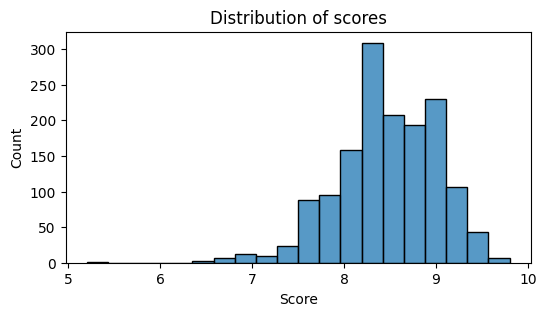

In [91]:
bins_number = 20
font = 12

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
plt.subplots_adjust(hspace=.25)

histplot_par = sns.histplot(data=hotels, 
                            x='score', bins=bins_number)
histplot_par.set_title('Distribution of scores', fontsize=font)
histplot_par.set_xlabel('Score')
histplot_par.set_ylabel('Count');

In [92]:
hotels = hotels.rename(columns={
    'name'            : 'hotel_name', 
    'address'         : 'hotel_address', 
    'score'           : 'average_score', 
    'reviews'         : 'total_number_of_reviews',
    'no_review_scores': 'additional_number_of_scoring'})

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1492 non-null   object 
 1   hotel_address                 1492 non-null   object 
 2   additional_number_of_scoring  1492 non-null   int64  
 3   average_score                 1492 non-null   float64
 4   total_number_of_reviews       1492 non-null   int64  
 5   lat                           1492 non-null   float64
 6   lng                           1492 non-null   float64
 7   country                       1492 non-null   object 
 8   city                          1492 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 105.0+ KB


***

# 3. Работа с признаками рецензентов

In [93]:
#Объединим датафрейм отелей с основным
data_drop_list = [
    'hotel_address',
    'average_score',
    'total_number_of_reviews',
    'lat', 'lng', 'additional_number_of_scoring'
]


data = data.drop(data_drop_list, axis = 1)

In [94]:
data = data.merge(hotels, on='hotel_name', how='left')

In [95]:
# Сугруппируем лучшие оценки по странам
grouped = data.groupby('country')['reviewer_score'].agg(['mean', 'median', 'count'])

grouped

,mean,median,count
country,,,
Austria,6.407800,8.3,38655
France,6.299141,7.9,59928
Italy,6.261022,7.9,37147
Netherlands,6.351014,8.3,57214
Spain,6.418939,8.3,60493
United Kingdom,6.246694,7.9,262301


In [96]:
# Разделим рецензентов по национальности и найдем их долю
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda s: s.strip())

print('There are '+str(data['reviewer_nationality'].nunique())+' different reviewers nationalities in the dataset.\n')
data['reviewer_nationality'].value_counts(normalize=True).head(12)

There are 227 different reviewers nationalities in the dataset.



United Kingdom              0.475524
United States of America    0.068711
Australia                   0.042048
Ireland                     0.028749
United Arab Emirates        0.019845
Saudi Arabia                0.017356
Netherlands                 0.017009
Switzerland                 0.016826
Germany                     0.015397
Canada                      0.015306
France                      0.014147
Israel                      0.012817
Name: reviewer_nationality, dtype: float64

In [97]:
# Добавим признак местного рецензента, если страна отеля и рецензента совпадают
data['local_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)

data['local_reviewer'].value_counts(normalize=True)

0    0.654078
1    0.345922
Name: local_reviewer, dtype: float64

#### Примерно две трети рецензетов иностранцы и треть - местные ^

In [98]:
def reduce_categories_number(df, col, n):
    '''
    Функция принимает датасет df, колонку col и n - количество наиболее частых категорий.
    Категории не входящие в n наиболее частых заменяются на 'Other'.
    Функция возвращает полученный датасет.
    '''
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df

data = reduce_categories_number(data, 'reviewer_nationality', 11)

In [99]:
# создадим фрейм с данными о странах по индексу удовлетворенности жизнью. Данные взяты с Википедии: https://en.wikipedia.org/wiki/Satisfaction_with_Life_Index
swl_df = pd.DataFrame([['United Kingdom', 236.67],
                       ['United States of America', 246.67],
                       ['Australia', 243.33],
                       ['Ireland', 253.33],
                       ['United Arab Emirates', 246.67],
                       ['Saudi Arabia', 243.33],
                       ['Netherlands', 250],
                       ['Switzerland', 273.33],
                       ['Germany', 240],
                       ['Canada', 253.33],
                       ['France', 240],
                       ['Israel', 223.33],
                       ['Turkey', 176.67],
                       ['Spain', 233.33],
                       ['Other', 247.88], ], 
                      columns=['country', 'swl'])

swl_df

,country,swl
0,United Kingdom,236.67
1,United States of America,246.67
2,Australia,243.33
3,Ireland,253.33
4,United Arab Emirates,246.67
5,Saudi Arabia,243.33
6,Netherlands,250.00
7,Switzerland,273.33
8,Germany,240.00
9,Canada,253.33


In [100]:
# объединим с основной датой:

data = data.join(swl_df.set_index('country'), on='reviewer_nationality')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   review_date                                 515738 non-null  datetime64[ns]
 1   hotel_name                                  515738 non-null  object        
 2   reviewer_nationality                        515738 non-null  object        
 3   negative_review                             515738 non-null  object        
 4   review_total_negative_word_counts           515738 non-null  int64         
 5   positive_review                             515738 non-null  object        
 6   review_total_positive_word_counts           515738 non-null  int64         
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 8   tags                                        515738 non-null  object       

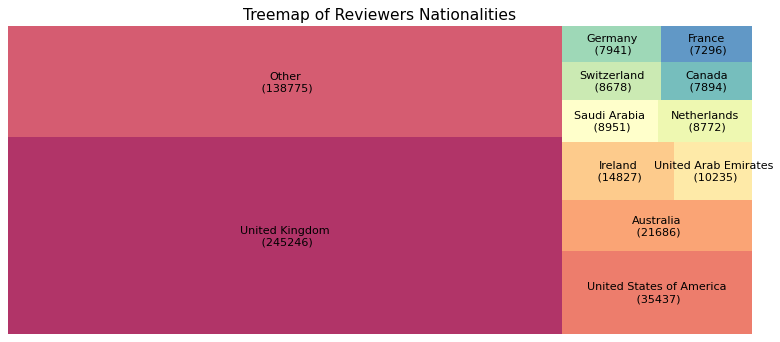

In [101]:


chart_column_treemap(data, 'reviewer_nationality', 
                     'Treemap of Reviewers Nationalities', size=[12, 5])


#### ^^^ Судя по всему, больше всех по Европе путешествуют Британцы ^^^

In [102]:
# Попробуем снова провести манипуляции с тегами

data['tags'] = data['tags'].apply(lambda s: s[1:] if s[0] == '[' else s)
data['tags'] = data['tags'].apply(lambda s: s[:-1] if s[-1] == ']' else s)

data['tags'] = data['tags'].apply(lambda s: s.replace('\' ', ''))
data['tags'] = data['tags'].apply(lambda s: s.replace(' \'', ''))

data['tags_list'] = data['tags'].apply(lambda s: s.split(', '))

data['number_of_tags'] = data['tags_list'].apply(len)

data['number_of_tags'].value_counts(normalize=True)

5    0.577470
4    0.410216
3    0.010674
6    0.001464
2    0.000165
1    0.000012
Name: number_of_tags, dtype: float64

In [103]:

display(data['tags'].head())
display(data['tags_list'].head())

0                                                            Leisure trip, Couple, Double Room, Stayed 2 nights
1                                                              Leisure trip, Group, Triple Room, Stayed 1 night
2                       Business trip, Solo traveler, Twin Room, Stayed 1 night, Submitted from a mobile device
3                                                 Leisure trip, Couple, Ambassador Junior Suite, Stayed 1 night
4    Business trip, Solo traveler, Classic Double or Twin Room, Stayed 2 nights, Submitted from a mobile device
Name: tags, dtype: object

0                                                            [Leisure trip, Couple, Double Room, Stayed 2 nights]
1                                                              [Leisure trip, Group, Triple Room, Stayed 1 night]
2                       [Business trip, Solo traveler, Twin Room, Stayed 1 night, Submitted from a mobile device]
3                                                 [Leisure trip, Couple, Ambassador Junior Suite, Stayed 1 night]
4    [Business trip, Solo traveler, Classic Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
Name: tags_list, dtype: object

##### Главные тезисы первоначального анализа тегов:
- используется максимум 6 тегов;
- есть двоичные теги - 'With a pet' и 'Submitted from a mobile device'. Можно кодировать их с помощью 1 и 0;
- есть тег, который описывает тип поездки - Leisure/Business поездка;
- есть тег, описывающий, кто путешествует - Solo, Group, Couple or Family;
- есть тег, описывающий продолжительность пребывания, например, 'Stayed 7 nights';
- наконец, есть тег, описывающий различные типы комнат.

In [104]:
# Закодируем признак осуществления отзыва: с мобильного устройства или нет
def from_mobile(tags_list):
    for element in tags_list:
        if 'Submitted from a mobile device' in element:
            return 1
    return 0

data['from_mobile'] = data['tags_list'].apply(from_mobile)

In [105]:
def chart_score_vs_column(
    df,                  # dataframe
    col,                 # columns
    title,               # title
    xlabel,              # X axis label
    ylabel,              # Y axis label

    size=[10, 5],        # size of the chart
    ylim=[5, 7],         # min/max of Y axis

                         # font sizes of:
    title_fontsize=16,   # title
    ticks_fontsize=12,   # ticks
    xlabel_fontsize=14,  # X axis label
    xticks_rotation=0,   # xticks rotation 
    ylabel_fontsize=14): # Y axis label
    
    grouped = df.groupby(col)['reviewer_score'].agg(['mean']).sort_values('mean')

    fig, ax = plt.subplots(figsize=(size[0], size[1]))

    plt.suptitle(title, size=title_fontsize)
    bar_types = sns.barplot(x=grouped.index, y=grouped['mean'])

    for p in bar_types.patches:
        bar_types.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.4, p.get_height()),
        ha='center', va='bottom', fontsize=int((title_fontsize+ticks_fontsize)/2))

    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(xlabel, size=xlabel_fontsize)
    plt.ylabel(ylabel, size=ylabel_fontsize)
    plt.xticks(fontsize=ticks_fontsize)
    plt.xticks(rotation=xticks_rotation);

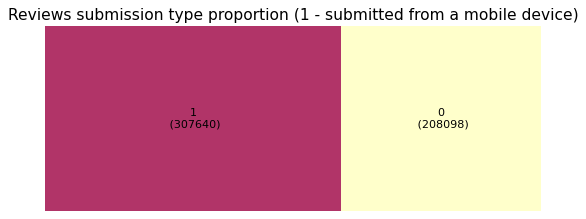

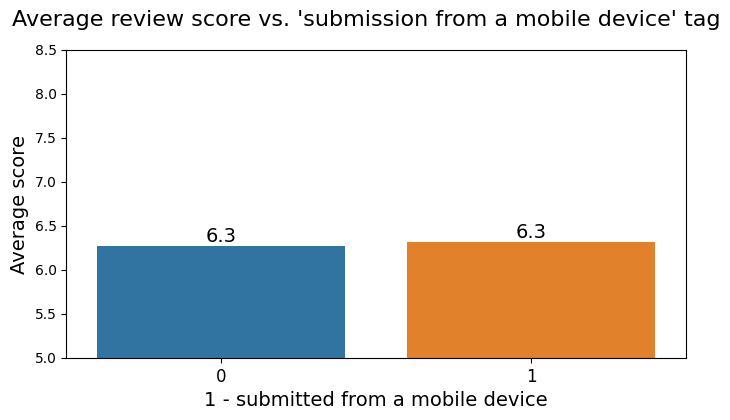

In [106]:
chart_column_treemap(data, 'from_mobile', 
                     'Reviews submission type proportion (1 - submitted from a mobile device)', size=[8, 3])

chart_score_vs_column(data, 'from_mobile', 
                      'Average review score vs. \'submission from a mobile device\' tag', 
                      '1 - submitted from a mobile device', 
                      'Average score', 
                      size=[8, 4], ylim=[5, 8.5])

#### Оценки с мобильных устройств совсем немного выше, чем с десктопов, но количественно их больше, поэтому признак является довольно важным

In [107]:
# Вытащим из тегов типы путешествий
def get_trip_type(tags_list):
    for element in tags_list:
        if 'trip' in element:
            return element
    return 'Unknown'

data['trip_type'] = data['tags_list'].apply(get_trip_type)

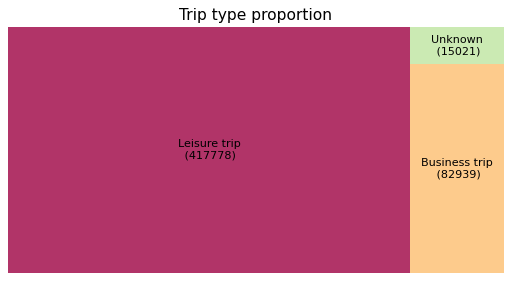

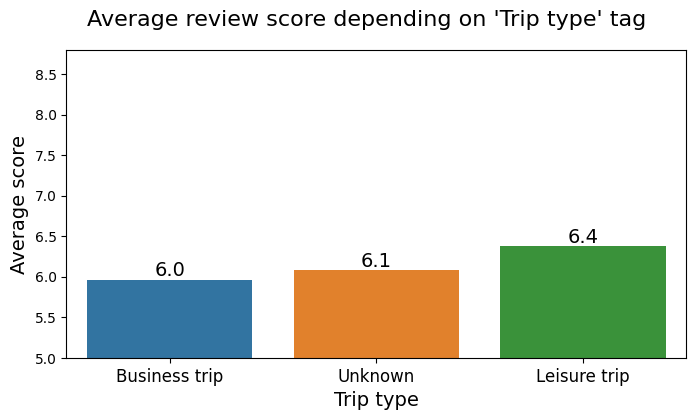

In [108]:
chart_column_treemap(data, 'trip_type', 
                     'Trip type proportion', size=[8, 4])

chart_score_vs_column(data, 'trip_type', 
                      'Average review score depending on \'Trip type\' tag', 
                      'Trip type', 
                      'Average score', 
                      size=[8, 4], ylim=[5, 8.8])

#### Как видим, самым популярным типом путешествия является досуговый, а также люди при досуговом путешествии ставят самые высокие оценки. При бизнес-поездках ставятся самые низкие оценки, что ожидаемо, так как такие рецензенты ставят оценки более взвешенно и претенциозно.

In [109]:
# Определим тип путешественника по уровню стека: в одиночку, компанией, парой или с семьей (или другие типы): 
def get_traveller_type(tags_list):
    for element in tags_list:
        if 'Solo' in element:
            return 'Solo'
        elif 'Group' in element:
            return 'Group'
        elif 'Couple' in element:
            return 'Couple'
        elif 'Family' in element:
            return 'Family'
    return 'Other'

data['traveller_type'] = data['tags_list'].apply(get_traveller_type)

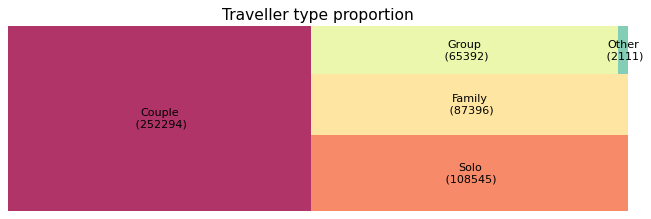

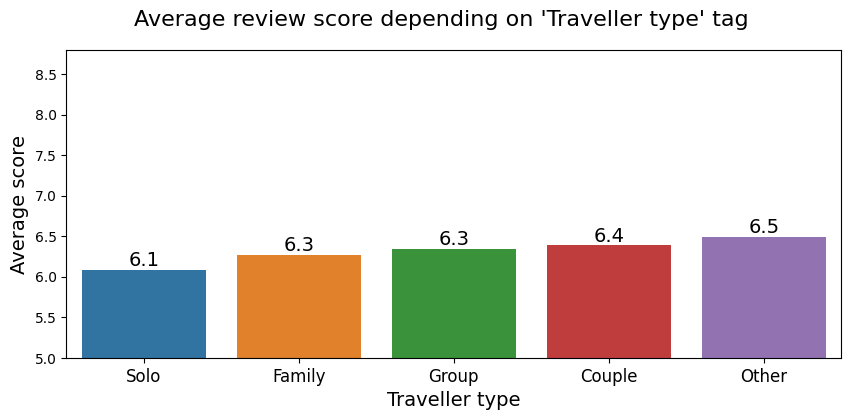

In [110]:
# Визуализируем признаки:
chart_column_treemap(data, 'traveller_type', 
                     'Traveller type proportion', size=[10, 3])

chart_score_vs_column(data, 'traveller_type', 
                      'Average review score depending on \'Traveller type\' tag', 
                      'Traveller type', 
                      'Average score', 
                      size=[10, 4], ylim=[5, 8.8])

#### Одинокие путешественники ставят самые низкие оценки, парами - самые высокие, и их доля самая многочисленная

In [111]:
# Разделим постояльцев отелей по количеству проведенных ночей:
def get_stay_length(tags_list):
    for element in tags_list:
        if 'night' in element and 'Stayed' in element:
            return element.split()[1]+' night(s)'
    return 0

data['stay_length'] = data['tags_list'].apply(get_stay_length)

In [112]:
# Сократим признак до 8 категорий: 7 самых популярных и прочие
data = reduce_categories_number(data, 'stay_length', 7)

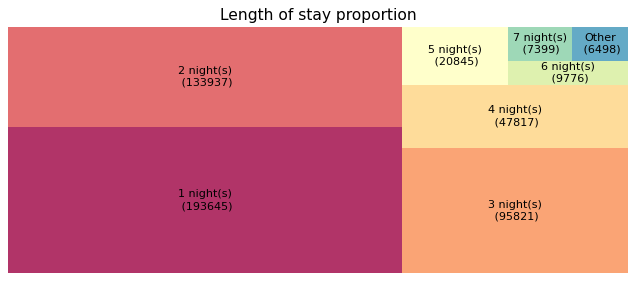

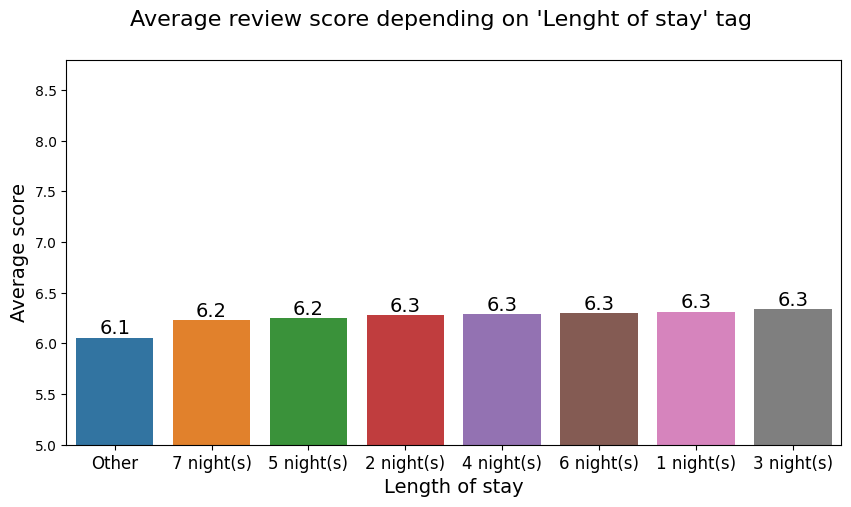

In [113]:
chart_column_treemap(data, 'stay_length', 
                     'Length of stay proportion', size=[10, 4])

chart_score_vs_column(data, 'stay_length', 
                      'Average review score depending on \'Lenght of stay\' tag', 
                      'Length of stay', 
                      'Average score', 
                      size=[10, 5], ylim=[5, 8.8])

#### Лучшие оценки ставят постояльцы на 3 ночи. Наихудшие - проживающие более недели.

In [114]:
# Определим самые популярные типы снимаемых номеров
def get_room_type(tags_list):
    for element in tags_list:
        if 'Room' in element:
            return element
    return 'Other'

data['room_type'] = data['tags_list'].apply(get_room_type)

data = reduce_categories_number(data, 'room_type', 7)

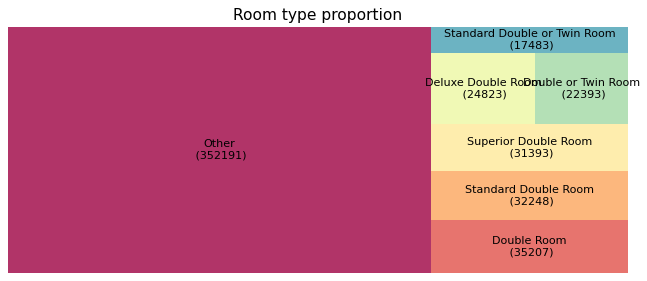

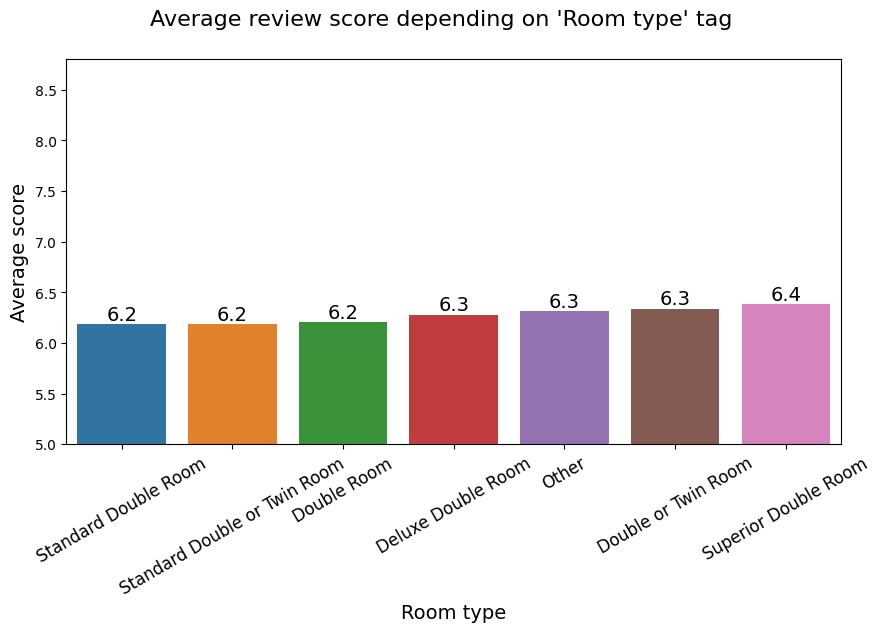

In [115]:
chart_column_treemap(data, 'room_type', 
                     'Room type proportion', size=[10, 4])

chart_score_vs_column(data, 'room_type', 
                      'Average review score depending on \'Room type\' tag', 
                      'Room type', 
                      'Average score', 
                      size=[10, 5], ylim=[5, 8.8], xticks_rotation=30)

***

# 4. Анализ дат и времени

In [116]:
data['review_date'] = pd.to_datetime(data['review_date'])

data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day
data['weekday'] = data['review_date'].dt.weekday + 1 # Monday = 1, ..., Sunday = 7

data = data.drop('review_date', axis=1)

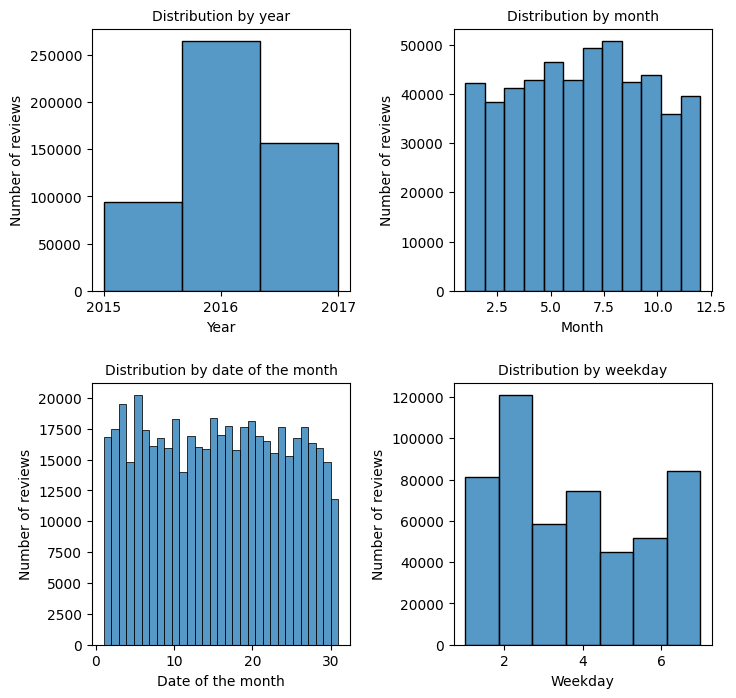

In [117]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
plt.subplots_adjust(hspace=.35, wspace=.4)

histplot1 = sns.histplot(data=data, x='year', bins=3, ax=axes[0,0])
histplot1.set_title('Distribution by year', fontsize=10)
histplot1.set_xlabel('Year')
histplot1.set_ylabel('Number of reviews')
histplot1.set_xticks([2015,2016,2017])

histplot2 = sns.histplot(data=data, x='month', bins=12, ax=axes[0,1])
histplot2.set_title('Distribution by month', fontsize=10)
histplot2.set_xlabel('Month')
histplot2.set_ylabel('Number of reviews')

histplot3 = sns.histplot(data=data, x='day', bins=31, ax=axes[1,0])
histplot3.set_title('Distribution by date of the month', fontsize=10)
histplot3.set_xlabel('Date of the month')
histplot3.set_ylabel('Number of reviews')

histplot3 = sns.histplot(data=data, x='weekday', bins=7, ax=axes[1,1])
histplot3.set_title('Distribution by weekday', fontsize=10)
histplot3.set_xlabel('Weekday')
histplot3.set_ylabel('Number of reviews');

^^^ Мы можем видеть некоторую связь между датами рецензирования и количеством отзывов, например, большинство отзывов пишется по вторникам и меньше всего по пятницам. Мы также видим, что большинство отзывов в нашем наборе данных относятся к 2016 году. Оставляем эту информацию в нашем наборе данных для будущего анализа.

In [118]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

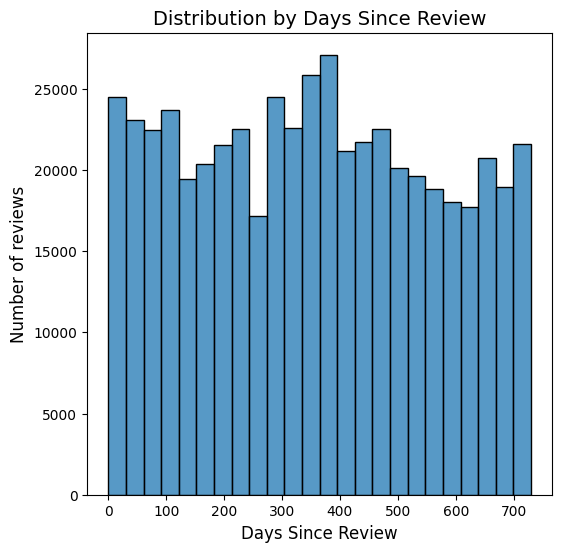

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plt.subplots_adjust(hspace=.25)

histplot = sns.histplot(data=data, x='days_since_review', bins=24)
histplot.set_title('Distribution by Days Since Review', fontsize=14)
histplot.set_xlabel('Days Since Review', fontsize=12)
histplot.set_ylabel('Number of reviews', fontsize=12);

***

# 5. Работа с отзывами

In [120]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [121]:
# All reviews to lower case
data['negative_review'] = data['negative_review'].apply(lambda s: s.lower())
data['positive_review'] = data['positive_review'].apply(lambda s: s.lower())

# Tokenize the reviews, e.g. make list of words instead of string

# Option 1 - with 'nltk.tokenize import word_tokenize'
# data['neg_review_tokenized'] = data['negative_review'].apply(word_tokenize)
# data['pos_review_tokenized'] = data['positive_review'].apply(word_tokenize)

# Option 2 - with s.split()
data['neg_review_tokenized'] = data['negative_review'].apply(lambda s: s.split())
data['pos_review_tokenized'] = data['positive_review'].apply(lambda s: s.split())

def remove_non_alpha(words_list):
    return [word for word in words_list if word.isalpha()]

# Leaving only alphabetic words
data['neg_review_tokenized'] = data['neg_review_tokenized'].apply(remove_non_alpha)
data['pos_review_tokenized'] = data['pos_review_tokenized'].apply(remove_non_alpha)

stop_words = stopwords.words('english')

def remove_stop_words(words_list):
    return [word for word in words_list if word not in stop_words]

# Removing stop words
# data['neg_review_tokenized'] = data['neg_review_tokenized'].apply(remove_stop_words)
# data['pos_review_tokenized'] = data['pos_review_tokenized'].apply(remove_stop_words)

# Recover string reviews column from tokenized reviews
data['negative_review'] = data['neg_review_tokenized'].apply(lambda s: ' '.join(s))
data['positive_review'] = data['pos_review_tokenized'].apply(lambda s: ' '.join(s))

data['review_total_negative_word_counts'] = data['neg_review_tokenized'].apply(len)
data['review_total_positive_word_counts'] = data['pos_review_tokenized'].apply(len)

In [122]:
def nltk_sentiment_analysis(df, col, prefix, sia):
#    sia = SentimentIntensityAnalyzer()
    df['polarity_scores'] = df[col].apply(sia.polarity_scores)
    
    df['nltk_'+prefix+'neg']      = df['polarity_scores'].apply(lambda x: x['neg'])
    df['nltk_'+prefix+'neu']      = df['polarity_scores'].apply(lambda x: x['neu'])
    df['nltk_'+prefix+'pos']      = df['polarity_scores'].apply(lambda x: x['pos'])
    df['nltk_'+prefix+'compound'] = df['polarity_scores'].apply(lambda x: x['compound'])

    df.drop('polarity_scores', axis=1, inplace=True)
    
    return df

In [123]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [124]:
def tb_sentiment_analysis(df, col, prefix):
    df['tb_'+prefix+'polarity']     = df[col].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['tb_'+prefix+'subjectivity'] = df[col].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    return df

def afinn_sentiment_analysis(df, col, prefix, afinn):
#     afinn = Afinn()
    df['afinn_'+prefix+'score'] = df[col].apply(lambda x: afinn.score(x))

    return df

In [125]:
nltk_sia = SentimentIntensityAnalyzer()
data = nltk_sentiment_analysis(data, 'negative_review', 'n_', nltk_sia)

data = tb_sentiment_analysis(data, 'negative_review', 'n_')

afinn_sia = Afinn()
data = afinn_sentiment_analysis(data, 'negative_review', 'n_', afinn_sia)

In [126]:
%%time

nltk_sia = SentimentIntensityAnalyzer()
data = nltk_sentiment_analysis(data, 'positive_review', 'p_', nltk_sia)

data = tb_sentiment_analysis(data, 'positive_review', 'p_')

afinn_sia = Afinn()
data = afinn_sentiment_analysis(data, 'positive_review', 'p_', afinn_sia)

CPU times: total: 9min 24s
Wall time: 9min 24s


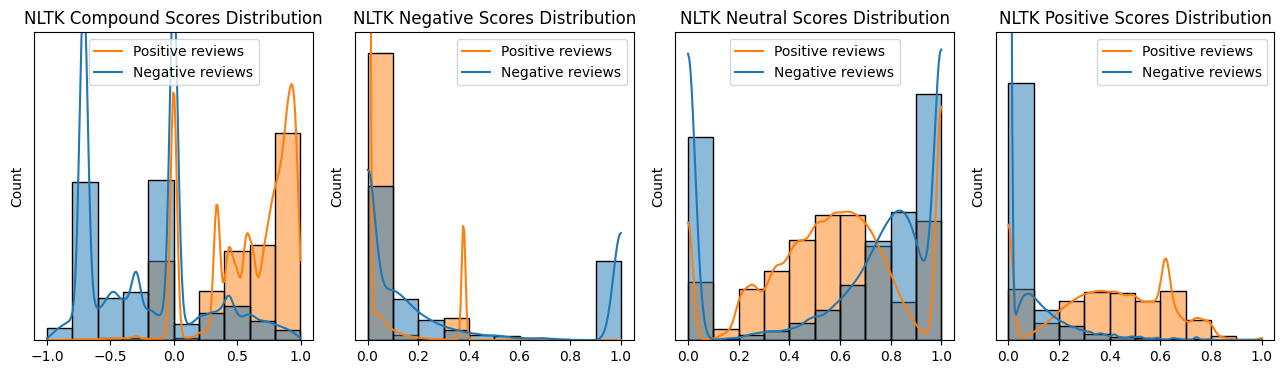

In [127]:
bins_number = 10
title_fontsize = 12
legend_labels = ['Positive reviews', 'Negative reviews']

afig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
plt.subplots_adjust(wspace=.15)

histplot1 = sns.histplot(data=data[['nltk_n_compound', 'nltk_p_compound']], 
                         bins=bins_number, ax=axes[0], kde=True)
histplot1.set_title('NLTK Compound Scores Distribution', fontsize=title_fontsize)
# histplot1.set_xlabel('Compound Scores')
# histplot1.set_ylabel('Count')
histplot1.set_yticks([])

histplot2 = sns.histplot(data=data[['nltk_n_neg', 'nltk_p_neg']], bins=bins_number, ax=axes[1], kde=True)
histplot2.set_title('NLTK Negative Scores Distribution', fontsize=title_fontsize)
# histplot2.set_xlabel('Negative Scores')
# histplot2.set_ylabel('Count')
histplot2.set_yticks([])

histplot3 = sns.histplot(data=data[['nltk_n_neu', 'nltk_p_neu']], bins=bins_number, ax=axes[2], kde=True)
histplot3.set_title('NLTK Neutral Scores Distribution', fontsize=title_fontsize)
# histplot3.set_xlabel('Neutral Scores')
# histplot3.set_ylabel('Count')
histplot3.set_yticks([])

histplot4 = sns.histplot(data=data[['nltk_n_pos', 'nltk_p_pos']], bins=bins_number, ax=axes[3], kde=True)
histplot4.set_title('NLTK Positive Scores Distribution', fontsize=title_fontsize)
# histplot4.set_xlabel('Positive Scores')
# histplot4.set_ylabel('Count')
histplot4.set_yticks([])

histplot1.axes.set_ylim(0, 300000)
histplot2.axes.set_ylim(0, 500000)
histplot3.axes.set_ylim(0, 200000)
histplot4.axes.set_ylim(0, 500000)

histplot1.legend(labels=legend_labels)
histplot2.legend(labels=legend_labels)
histplot3.legend(labels=legend_labels)
histplot4.legend(labels=legend_labels);

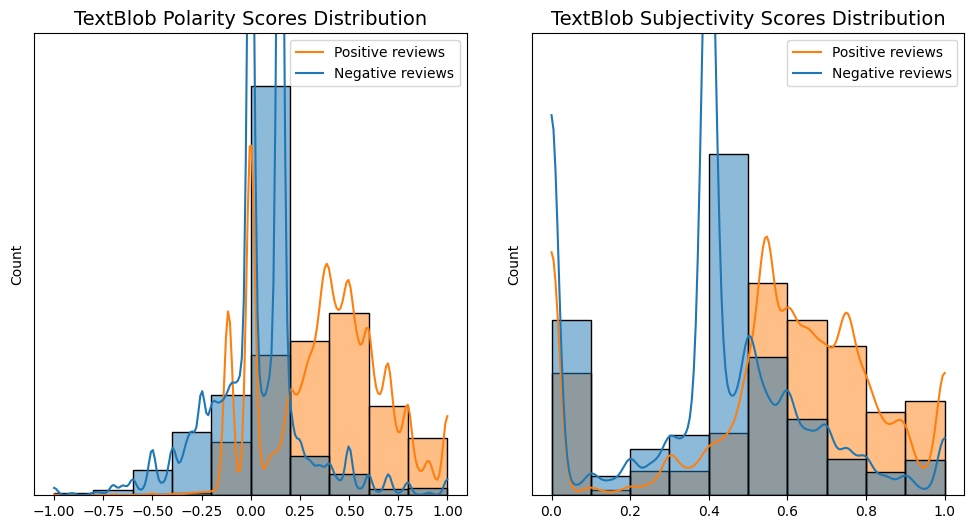

In [128]:
bins_number = 10
title_fontsize = 14
legend_labels = ['Positive reviews', 'Negative reviews']

afig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplots_adjust(wspace=.15)

histplot1 = sns.histplot(data=data[['tb_n_polarity', 'tb_p_polarity']], 
                         bins=bins_number, ax=axes[0], kde=True)
histplot1.set_title('TextBlob Polarity Scores Distribution', fontsize=title_fontsize)
# histplot1.set_xlabel('Compound Scores')
# histplot1.set_ylabel('Count')
histplot1.set_yticks([])

histplot2 = sns.histplot(data=data[['tb_n_subjectivity', 'tb_p_subjectivity']], 
                         bins=bins_number, ax=axes[1], kde=True)
histplot2.set_title('TextBlob Subjectivity Scores Distribution', fontsize=title_fontsize)
# histplot2.set_xlabel('Negative Scores')
# histplot2.set_ylabel('Count')
histplot2.set_yticks([])

histplot1.axes.set_ylim(0, 350000)
histplot2.axes.set_ylim(0, 250000)

histplot1.legend(labels=legend_labels)
histplot2.legend(labels=legend_labels);

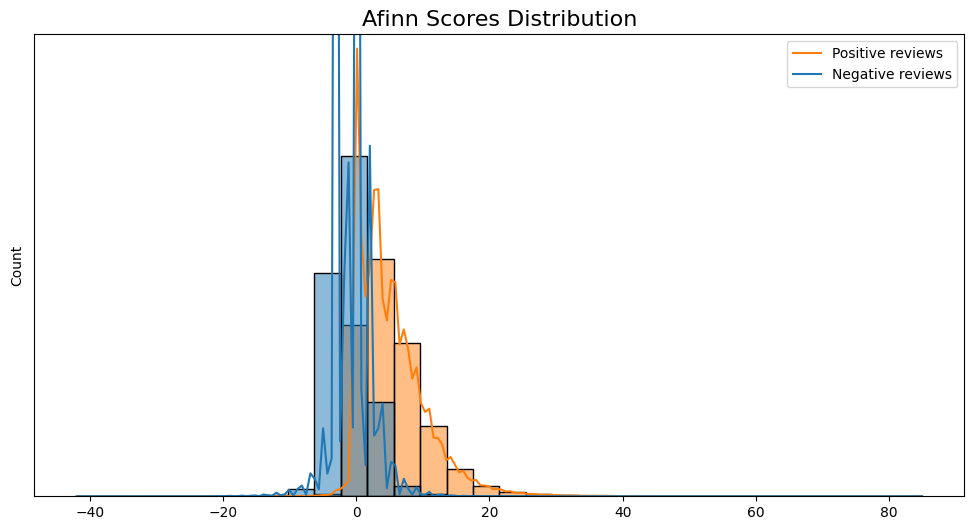

In [129]:
bins_number = 32
title_fontsize = 16
legend_labels = ['Positive reviews', 'Negative reviews']

afig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plt.subplots_adjust(wspace=.15)

histplot1 = sns.histplot(data=data[['afinn_n_score', 'afinn_p_score']], 
                         bins=bins_number, kde=True)
histplot1.set_title('Afinn Scores Distribution', fontsize=title_fontsize)
# histplot1.set_xlabel('Compound Scores')
# histplot1.set_ylabel('Count')
histplot1.set_yticks([])

histplot1.axes.set_ylim(0, 350000)

histplot1.legend(labels=legend_labels);

In [130]:
percentiles = [.01, .05, .1, .25, .5, .75, .9, .95, .99]

print(data['afinn_n_score'].describe(percentiles=percentiles), 
      data['afinn_p_score'].describe(percentiles=percentiles))

count    515738.000000
mean         -0.826183
std           2.691221
min         -42.000000
1%           -7.000000
5%           -4.000000
10%          -3.000000
25%          -3.000000
50%           0.000000
75%           0.000000
90%           2.000000
95%           3.000000
99%           7.000000
max          38.000000
Name: afinn_n_score, dtype: float64 count    515738.000000
mean          5.282428
std           5.141902
min         -26.000000
1%           -1.000000
5%            0.000000
10%           0.000000
25%           1.000000
50%           4.000000
75%           8.000000
90%          12.000000
95%          15.000000
99%          22.000000
max          85.000000
Name: afinn_p_score, dtype: float64


### Создание мешка слов

In [131]:
def add_bag_of_words(df, column, prefix, max_words=32):
    '''
    Input:
    - df;
    - column with text - should contain a string;
    - build a vocabulary that only consider the top max_words ordered by term frequency across the corpus.
      Otherwise, all features are used.

    Output:
    - df with added columns with 'bag of words';
    - list of words.
    '''
    # Convert a collection of text documents to a matrix of token counts.
    vectorizer = CountVectorizer(max_features=max_words) # stop_words='english'
    bow = vectorizer.fit_transform(df[column])

    count_array = bow.toarray()
    features = vectorizer.get_feature_names_out()
    
    prefixed_features = [prefix+element for element in features]
    
    bow_df = pd.DataFrame(data=count_array, columns=prefixed_features)
    
    return pd.concat([df, bow_df], ignore_index=False, axis=1), features

data, bow_neg = add_bag_of_words(data, 'negative_review', 'bow_n_')
data, bow_pos = add_bag_of_words(data, 'positive_review', 'bow_p_')

In [132]:
# Посмотрим на содержимое мешков слов 

max_length = 8

for word_length in range(0, max_length+1):
    if word_length >= 2:
        print('Negative BoW:', word_length)
    
    if word_length < max_length:
        print([word for word in bow_neg if len(word)==word_length])
    else:
        print([word for word in bow_neg if len(word)>=word_length])

print('')

for word_length in range(0, max_length+1):
    if word_length >= 2:
        print('Positive BoW:', word_length)
    
    if word_length < max_length:
        print([word for word in bow_pos if len(word)==word_length])
    else:
        print([word for word in bow_pos if len(word)>=word_length])

[]
[]
Negative BoW: 2
['as', 'at', 'be', 'in', 'is', 'it', 'no', 'of', 'on', 'to', 'we']
Negative BoW: 3
['and', 'but', 'for', 'had', 'not', 'the', 'was', 'you']
Negative BoW: 4
['from', 'have', 'room', 'that', 'they', 'very', 'were', 'with']
Negative BoW: 5
['hotel', 'small', 'there']
Negative BoW: 6
[]
Negative BoW: 7
[]
Negative BoW: 8
['breakfast', 'negative']

[]
[]
Positive BoW: 2
['at', 'in', 'is', 'it', 'no', 'of', 'to', 'we']
Positive BoW: 3
['and', 'bed', 'for', 'the', 'was']
Positive BoW: 4
['from', 'good', 'nice', 'room', 'very', 'were', 'with']
Positive BoW: 5
['clean', 'great', 'hotel', 'rooms', 'staff']
Positive BoW: 6
[]
Positive BoW: 7
['helpful']
Positive BoW: 8
['breakfast', 'comfortable', 'excellent', 'friendly', 'location', 'positive']


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 112 entries, hotel_name to bow_p_with
dtypes: float64(19), int64(78), object(15)
memory usage: 444.6+ MB


***

# 6. Отбор признаков

In [134]:
# Функция для построения кореляционной диаграммы признаков
def chart_correlation_heatmap(df, 
                              columns, 
                              title, 
                              method='pearson', 
                              correlation_threshold=.6):
    """Построение корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    correlation_matrix = df[columns].corr(method=method).abs()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix[correlation_matrix.abs() > correlation_threshold], 
                annot=True,
                annot_kws={"fontsize":9}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

In [135]:
# Разделяем признаки различных типов

# Категориальные - либо кодировать, либо удалить
categorical_columns = [
    'reviewer_nationality', 
    'country',
    'trip_type', 
    'traveller_type',
    'stay_length',
    'room_type'
]

# for col in categorical_columns:
#     data[col] = data[col].astype('category')

# Не цифровые, типа 'object', больше нам не нужны, можно удалить
object_columns = [
    'hotel_name',
    'negative_review',
    'positive_review',
    'neg_review_tokenized',
    'pos_review_tokenized',
    'tags',
    'hotel_address',
    'city',
    'tags_list',
    'sample'
]

# Признаки мешков слов
bow_columns = list(data.columns)[49:]

# Числовые признаки
numerical_columns = set(data.columns) - \
                    set(categorical_columns) - \
                    set(object_columns) - \
                    set(bow_columns)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_22016\3247181421.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  correlation_matrix = df[columns].corr(method=method).abs()


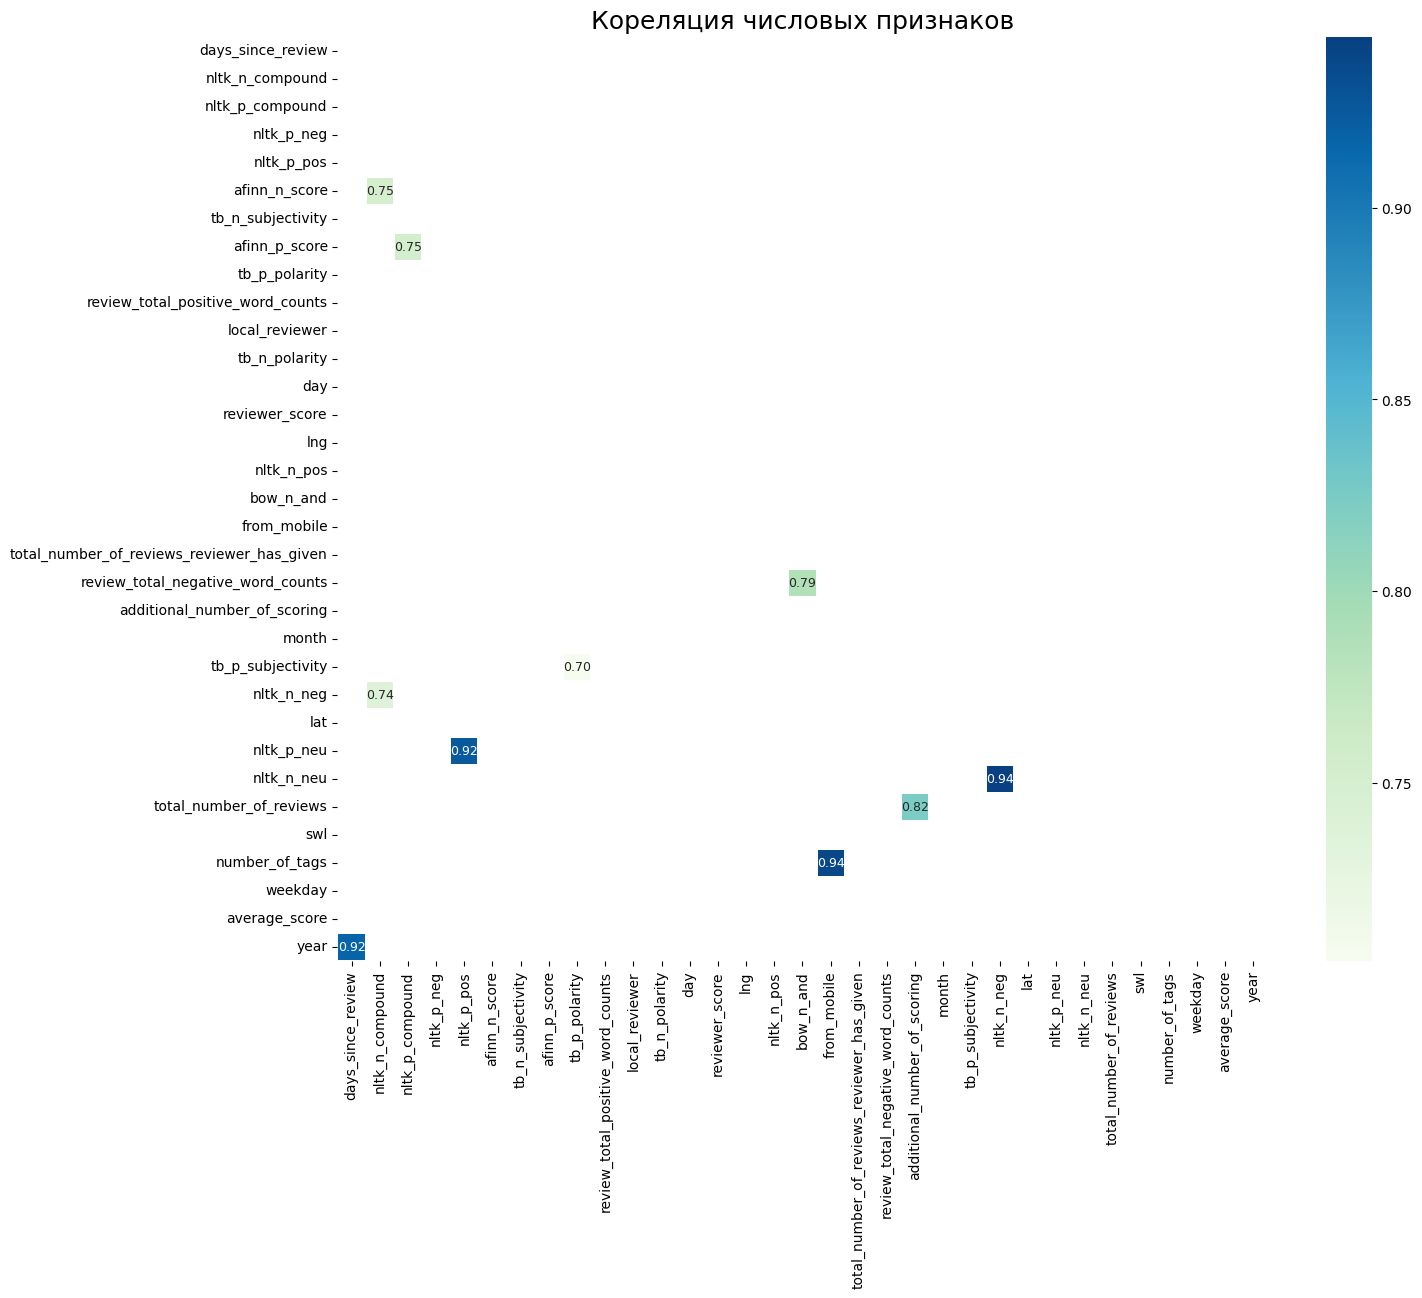

In [136]:
chart_correlation_heatmap(data, 
                          numerical_columns, 
                          'Кореляция числовых признаков',
                          correlation_threshold = .7)

In [137]:
def encode(df, column):
    '''
    Аргументы:
    - датафрейм - df;
    - имя колонки - column.
    
    Функция:
    - кодирует column при помощи OneHotEncoder;
    - добавляет содержащие разреженную матрицу колонки к df (если не сделано ранее);
    - печатает краткий отчёт о своих действиях;
    - возвращает полученный df и список добавленных колонок.
    '''   
    # Encoding
    one_hot_encoder = ce.OneHotEncoder(cols=column, use_cat_names=True)
    encoded = one_hot_encoder.fit_transform(df[column])
    
    # Checking if the encoded columns are already added to the dataset
    if set(one_hot_encoder.get_feature_names()).issubset(df.columns):
        pass
    else:
        df = pd.concat([df, encoded], axis=1, join='inner')
    
    # Geting the list of added columns
    added_columns = one_hot_encoder.get_feature_names()
    
    # Printing the result
    print('Encoded \''+column+'\' column, added '+str(len(added_columns))+ ' new columns.')
#     for column in added_columns:
#         print('\''+column+'\'')
#     print('')
    
    return df, added_columns

In [138]:
data, encoded_list = encode(data, 'reviewer_nationality')
data, encoded_list = encode(data, 'country')
data, encoded_list = encode(data, 'trip_type')
data, encoded_list = encode(data, 'traveller_type')
data, encoded_list = encode(data, 'stay_length')
data, encoded_list = encode(data, 'room_type')

c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Encoded 'reviewer_nationality' column, added 12 new columns.


c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Encoded 'country' column, added 6 new columns.


c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Encoded 'trip_type' column, added 3 new columns.


c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Encoded 'traveller_type' column, added 5 new columns.


c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Encoded 'stay_length' column, added 8 new columns.


c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
c:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Encoded 'room_type' column, added 7 new columns.


In [139]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

data.drop(object_columns, axis = 1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 138 entries, review_total_negative_word_counts to room_type_Deluxe Double Room
dtypes: float64(19), int64(119)
memory usage: 563.1 MB


***

# 8. Построение модели

In [140]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет         
X = train_data.drop(['reviewer_score'], axis=1)
 

In [141]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [142]:
# проверяем
X.shape, X_train.shape, X_test.shape

((386803, 136), (309442, 136), (77361, 136))

In [143]:
%%time  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


CPU times: total: 55min 38s
Wall time: 3min 56s


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


In [144]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12071703265764697


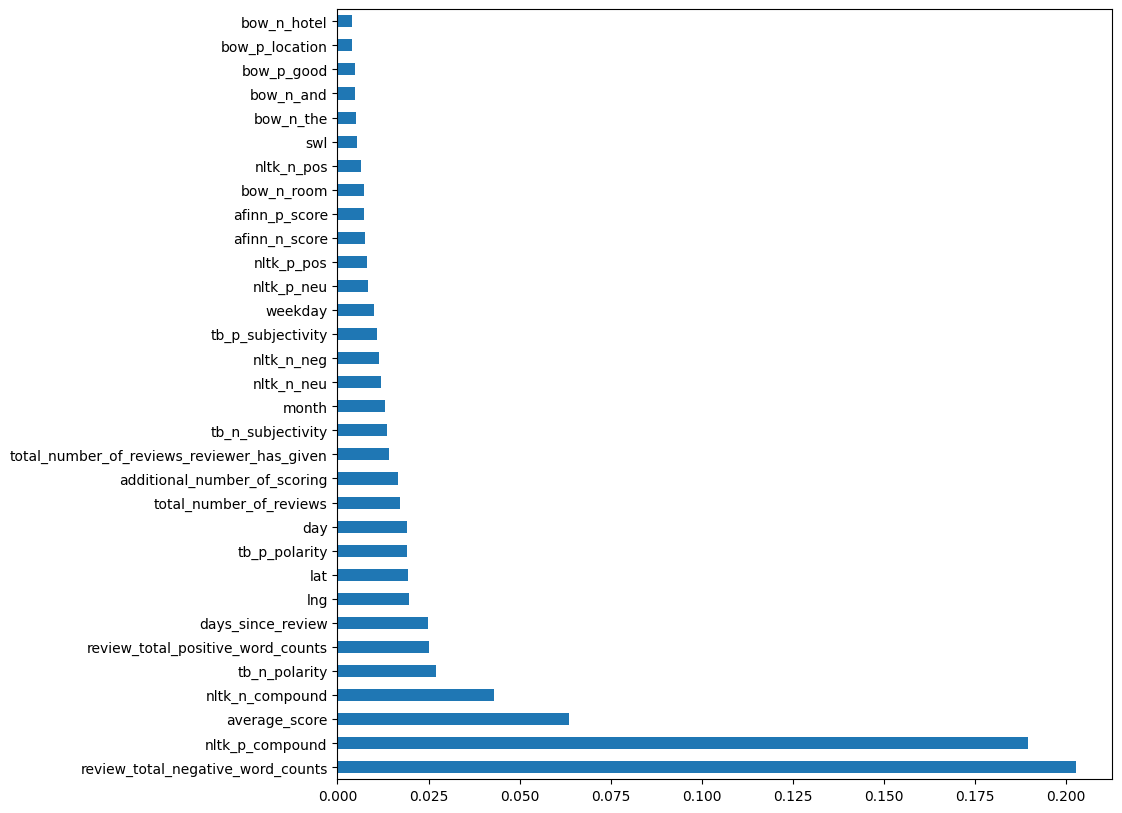

In [145]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(32).plot(kind='barh');

In [146]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [147]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [148]:
for i in range(len(predict_submission)):
    predict_submission[i] = round(predict_submission[i], 1)

len(predict_submission)

128935

In [149]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(5)

,reviewer_score,id
0,8.6,488440
1,7.2,274649
2,9.1,374688
3,9.8,404352
4,9.7,451596


In [150]:
sample_submission.describe()

,reviewer_score,id
count,128935.000000,128935.000000
mean,8.371853,258065.135533
std,1.168022,148917.547662
min,3.000000,2.000000
25%,7.700000,129124.000000
50%,8.700000,257459.000000
75%,9.300000,387599.000000
max,10.000000,515737.000000
